## Step 1 - Getting the point cloud and Computing Vietoris-Rips Complexes and Cohomology

Populating the interactive namespace from numpy and matplotlib


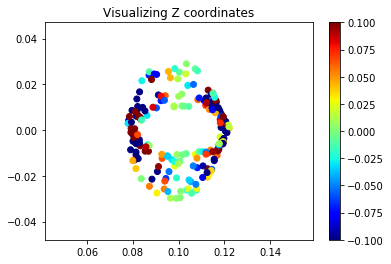

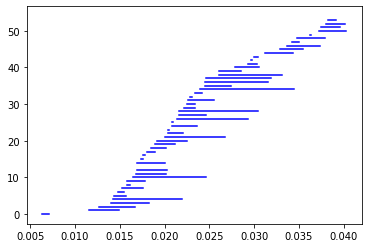

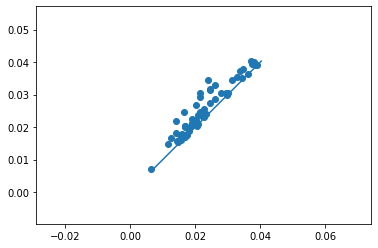

In [11]:
%pylab inline
import examples as eg
import numpy as np
from numpy import *
import dionysus

numpy.random.seed(seed=1234)

points = eg.double_pinched_torus_example(n=200,a=.2,b=.2,c=2,d=.1)
#Now we can plot the points using hue to show the Z coordinate
plt.scatter(points[:,0], points[:,1], c = points[:,2], cmap = 'jet')
plt.clim(-.1, .1)
plt.colorbar()
plt.axis('equal')
plt.title('Visualizing Z coordinates')
plt.figure()


#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
prime = 11 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(points, 2, 1.) #Vietoris-Rips complex up to dimension 2 and maximal distance 4
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 2 - Selecting the cocycle and visualization.

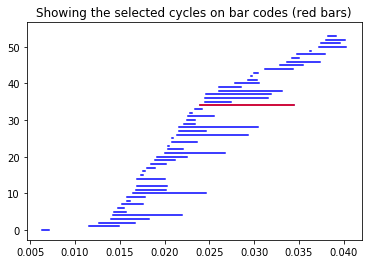

[0.023941025137901306, 0.034453943371772766]


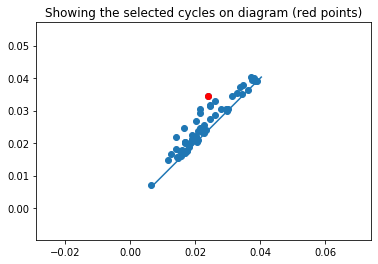

(0.023941,0.0344539)


In [13]:
persistence_threshold = 0.01
bars = [bar for bar in dgms[1] if bar.death-bar.birth > persistence_threshold] 
#choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > persistence_threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > persistence_threshold][0],'r')
plt.title('Showing the selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > persistence_threshold] 
for Lt3 in Lt1:
    print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Showing the selected cycles on diagram (red points)')
plt.show()
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]
#This is the same as choosing the maximal persistent cocycle when there is only one candidate cocycle.
#print(chosen_cocycle)
print(chosen_bar)

## Step 3 - Display the scatter points sampled from the manifold

In [14]:
pt = max(dgms[1], key = lambda pt: pt.death - pt.birth)
#print(pt)
chosen_cocycle = cp.cocycle(pt.data)
chosen_bar     = [bar for bar in dgms[1] if bar.death==pt.death and bar.birth==pt.birth]
chosen_bar     = chosen_bar[0]
#print(chosen_cocycle)
print(chosen_bar)
#fill_rips() computes Vietoris–Rips filtrations (up to a specified skeleton dimension and distance r).

(0.023941,0.0344539)


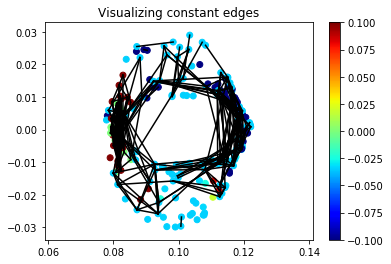

In [16]:
#If it is computed the smoothed coefficients can be used as initial condition for the optimization code
#hrluo: However, this optimization problem seems extremely sensitive to the initialization, the choice of L^2 smoothed coordinates does not seem to be 
vr_complex = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_complex, chosen_cocycle, prime)
##To smooth the cocycle and convert it to the corresponding *circular coordinates*, we need to choose a complex, 
##in which we do the smoothing. 
##Here we select the complex in the filtration that exists at the midvalue of the persistence bar, (pt.death + pt.birth)/2:
##or the complex with the maximal birth
'''
https://mrzv.org/software/dionysus2/tutorial/cohomology.html
'''

toll = 1e-7
p,val = (chosen_bar,coords)

#Show the constant edges first.
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
        #Only want edges in dim 1.
    elif s.data > thr:
        #print(s.data)
        #Only want those edges that exist when the chosen_bar is born.
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([points[s[0],:],points[s[1],:]])
        
edges_costant = np.array(edges_costant)
plot(edges_costant.T[0,:],edges_costant.T[1,:], c='k')
#Now we can plot the points using hue to show the circular coordinate
plt.scatter(points[:,0], points[:,1], c = coords, cmap = 'jet')
plt.clim(-.1, .1)
plt.colorbar()
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()


## Step 4 - Second smoothing using a new cost function

In [17]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)
l2_cocycle = l2_cocycle.reshape(-1, 1)

#np.zeros(l2_cocycle.shape[0])
#l2_cocycle.shape
#f-bdry*l2_cocycle

ZV = np.zeros(l2_cocycle.shape[0])
ZV = ZV.reshape(l2_cocycle.shape[0],1)
ZV.shape

(200, 1)

In [18]:
import tensorflow as tf
x1_data = tf.Variable(initial_value=tf.random_uniform([1], -10, 10),name='x1')
x2_data = tf.Variable(initial_value=tf.random_uniform([1], -10, 10), name='x2')

# Loss function
y = tf.add(tf.pow(tf.subtract(1.0, x1_data), 2.0), 
           tf.multiply(10.0, tf.subtract(x2_data,tf.pow(x1_data, 2.0))), 'y')

opt = tf.train.GradientDescentOptimizer(0.1)
opt = tf.train.AdamOptimizer(0.1)
train = opt.minimize(y)

sess = tf.Session()

sess.run(tf.global_variables_initializer())

for step in range(200):
    sess.run(train)
    if step % 10 == 0:
        print(step, sess.run(x1_data), sess.run(x2_data), sess.run(y))

/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/henry/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 [-3.7829518] [4.9194837] [-71.03578]
10 [-4.7923784] [3.9194856] [-156.92241]
20 [-5.8390927] [2.9194853] [-264.982]
30 [-6.940476] [1.9194839] [-399.45612]
40 [-8.102332] [0.9194829] [-564.43066]
50 [-9.323356] [-0.08051763] [-763.48315]
60 [-10.598764] [-1.0805173] [-999.61194]
70 [-11.922569] [-2.0805175] [-1275.289]
80 [-13.288721] [-3.080517] [-1592.5387]
90 [-14.69161] [-4.0805182] [-1953.0126]
100 [-16.126234] [-5.0805173] [-2358.0515]
110 [-17.588226] [-6.0805163] [-2808.74]
120 [-19.073801] [-7.080517] [-3305.9463]
130 [-20.5797] [-8.080519] [-3850.3623]
140 [-22.103113] [-9.080523] [-4442.5273]
150 [-23.641638] [-10.080526] [-5082.865]
160 [-25.193192] [-11.08053] [-5771.6904]
170 [-26.75599] [-12.080534] [-6509.2393]
180 [-28.328478] [-13.080538] [-7295.673]
190 [-29.909327] [-14.080542] [-8131.0967]


In [42]:
import tensorflow as tf
#Following seems working, c.f. 
#https://stackoverflow.com/questions/55552715/tensorflow-2-0-minimize-a-simple-function
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

#type(bdry)
#scipy.sparse.csr.csr_matrix
B_mat = bdry.todense()

#print(f.shape)
#print((B_mat*l2_cocycle).shape)

###L1 in tensorflow language
#cost_z = tf.reduce_sum( tf.abs(f - B_mat @ z) )
###L2 in tensorflow language
#cost_z = tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),2 ) )
#Lp+alpha*Lq norm in tensorflow language
lp=2
lq=1
alpha=0
#cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
iter=2501
init_val=l2_cocycle
##########
#Gradient Descedent Optimizer
z = tf.Variable(initial_value=init_val, name='z')
opt = tf.train.GradientDescentOptimizer(0.1)
cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
train = opt.minimize(cost_z)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(iter):
    sess.run(train)
    if step % 500 == 0:
        print('GD',step, sess.run(cost_z))

res_gd=sess.run(z)
##########

##########
#Adams Optimizer
z = tf.Variable(initial_value=init_val, name='z')
opt = tf.train.AdamOptimizer(0.1)
cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
train = opt.minimize(cost_z)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(iter):
    sess.run(train)
    if step % 500 == 0:
        print('Adam',step, sess.run(cost_z))

res_adam=sess.run(z)
##########

##########
#AdagradOptimizer
z = tf.Variable(initial_value=init_val, name='z')
opt = tf.train.AdagradOptimizer(0.1)
cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)
train = opt.minimize(cost_z)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(iter):
    sess.run(train)
    if step % 500 == 0:
        print('Adagrad',step, sess.run(cost_z))

res_adagrad=sess.run(z)
##########

GD 0 2.355264062438112
GD 500 2.186241020292146
GD 1000 2.186228099851682
GD 1500 2.186228089058638
GD 2000 2.18622808901949
GD 2500 2.1862280890153256
Adam 0 5.05476326823913
Adam 500 2.1907301317274355
Adam 1000 2.1946066003797067
Adam 1500 2.1996531698856603
Adam 2000 2.1944666865550526
Adam 2500 2.188659519347179
Adagrad 0 2.3334684211690178
Adagrad 500 2.1862280895636315
Adagrad 1000 2.1862280890146693
Adagrad 1500 2.1862280890146693
Adagrad 2000 2.186228089014669
Adagrad 2500 2.1862280890146693


In [20]:
print(np.ptp(res_gd,axis=0))
print(np.ptp(res_adam,axis=0))
print(np.ptp(res_adagrad,axis=0))

[4.99998082]
[1.02309661]
[0.58967302]


In [22]:
def plotCir(res,keywrd='TensorFlow'):
    color = np.mod(res.T[0,:],1)

    toll = 1e-5#tolerance for constant edges
    edges_constant = []
    thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
    for s in vr:
        if s.dimension() != 1:
            continue
        elif s.data > thr:
            break
        if abs(color[s[0]]-color[s[1]]) <= toll:
            edges_constant.append([points[s[0],:],points[s[1],:]])
    edges_constant = np.array(edges_constant)        
    #scatter(*points.T, c=color, cmap="hsv", alpha=.5)
    
    scatter(points.T[0,:],points.T[1,:],s=20, c=color, cmap="jet")
    plt.clim(-1, 1)
    plt.colorbar()
    plt.axis('equal')
    plt.title('Z_{0:d} coefficient smoothed values mod 1 \n {1:.2f}*L{2:d} + {3:.2f}*L{4:d} norm ({5})'.format(prime,1-alpha,lp,alpha,lq,keywrd))
    #plot(*edges_constant.T, c='k')
    if edges_constant.shape[0]>0:
        plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k', alpha=1) 
    plt.savefig('ExampleDPT_Plot_Z{}_{}_L{}+{}_L{}_{}.png'.format(prime,1-alpha,lp,alpha,lq,keywrd))
    plt.show()

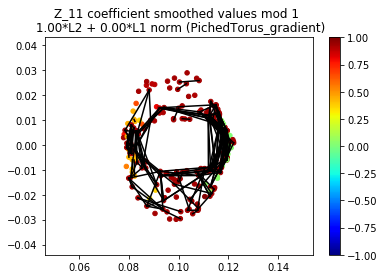

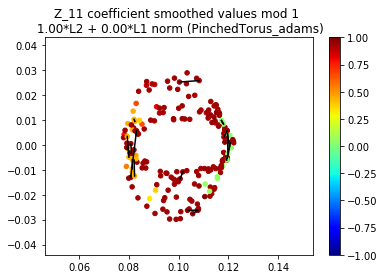

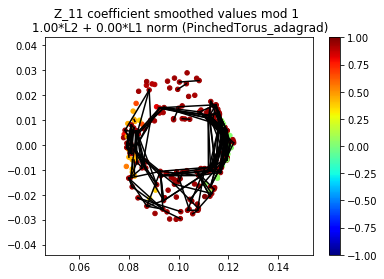

In [43]:
plotCir(res_gd,'PichedTorus_gradient')
plotCir(res_adam,'PinchedTorus_adams')
plotCir(res_adagrad,'PinchedTorus_adagrad')